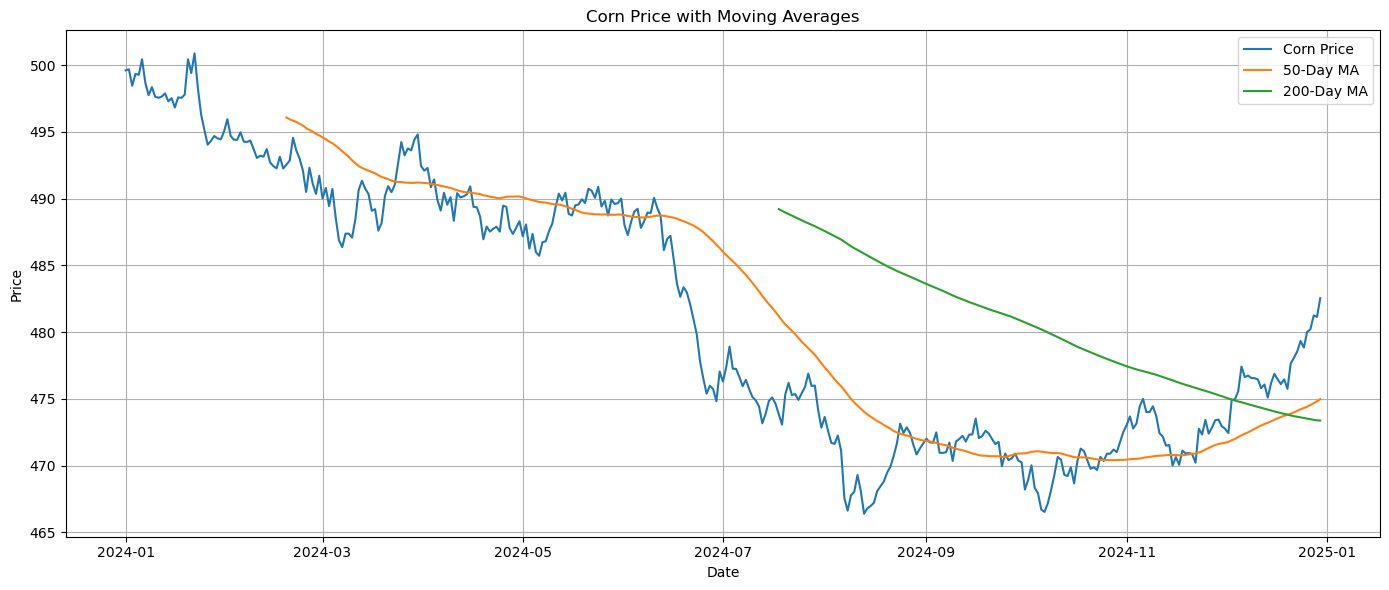

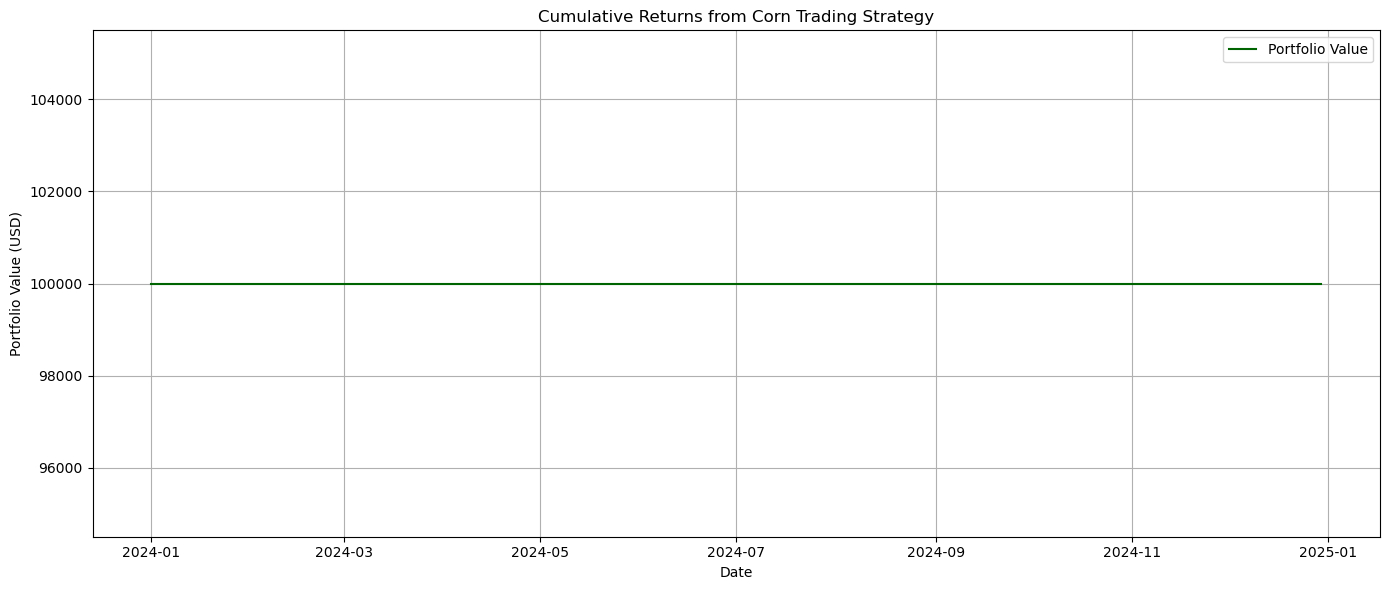

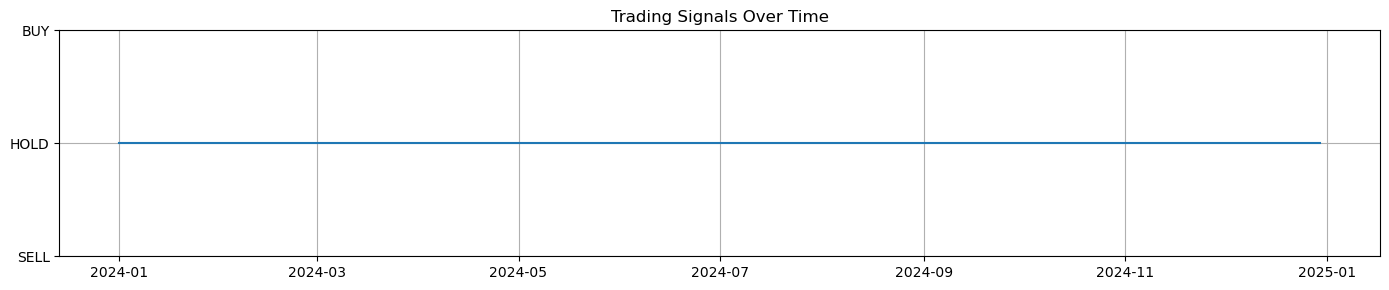

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Simulate 365 days of corn price data and weather conditions
np.random.seed(42)
days = 365
dates = pd.date_range(start='2024-01-01', periods=days)

temperature = 20 + 10 * np.sin(2 * np.pi * np.arange(days) / 365) + np.random.normal(0, 3, days)
rainfall = 4 + 3 * np.cos(2 * np.pi * np.arange(days) / 365) + np.random.exponential(scale=2, size=days)

# Simulate corn prices with seasonal effects
corn_price = 500 + 5 * np.sin(2 * np.pi * np.arange(days) / 365) + np.cumsum(np.random.normal(0, 1, days))

# Calculate 50-day and 200-day moving averages
ma_50 = pd.Series(corn_price).rolling(window=50).mean()
ma_200 = pd.Series(corn_price).rolling(window=200).mean()

# Strategy: Buy signal when MA50 crosses above MA200 and weather indicates supply risk
# Weather signal: temp > 28 and rainfall < 4 => moderate drought risk
signals = []
returns = [0]
capital = 100000
position = False
position_value = capital

for i in range(1, days):
    weather_signal = temperature[i] > 28 and rainfall[i] < 4
    ma_signal = ma_50[i] > ma_200[i] if not np.isnan(ma_50[i]) and not np.isnan(ma_200[i]) else False

    if ma_signal and weather_signal and not position:
        position = True
        buy_price = corn_price[i]
        print(f"BUY triggered on {dates[i]} at price {corn_price[i]:.2f}")
        signals.append('BUY')
    elif position and (not ma_signal or not weather_signal):
        position = False
        sell_price = corn_price[i]
        daily_return = (sell_price - buy_price) / buy_price
        capital *= (1 + daily_return)
        position_value = capital
        print(f"SELL triggered on {dates[i]} at price {corn_price[i]:.2f} | Return: {daily_return:.2%}")
        returns.append(daily_return)
        signals.append('SELL')
    else:
        returns.append(0)
        signals.append('HOLD')

# Pad signals to align length
signals = ['HOLD'] * (days - len(signals)) + signals

# Create DataFrame
data = pd.DataFrame({
    'Date': dates,
    'Temperature': temperature,
    'Rainfall': rainfall,
    'CornPrice': corn_price,
    'MA_50': ma_50,
    'MA_200': ma_200,
    'Signal': signals,
    'DailyReturn': returns
})
data['CumulativeReturn'] = (1 + data['DailyReturn']).cumprod() * 100000

# Plot 1: Corn price and moving averages
plt.figure(figsize=(14, 6))
plt.plot(data['Date'], data['CornPrice'], label='Corn Price')
plt.plot(data['Date'], data['MA_50'], label='50-Day MA')
plt.plot(data['Date'], data['MA_200'], label='200-Day MA')
plt.title('Corn Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Cumulative returns
plt.figure(figsize=(14, 6))
plt.plot(data['Date'], data['CumulativeReturn'], label='Portfolio Value', color='darkgreen')
plt.title('Cumulative Returns from Corn Trading Strategy')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (USD)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot 3: Signal timeline
signal_numeric = pd.Series(data['Signal']).map({'HOLD': 0, 'BUY': 1, 'SELL': -1})
plt.figure(figsize=(14, 3))
plt.plot(data['Date'], signal_numeric, label='Trade Signal')
plt.yticks([-1, 0, 1], ['SELL', 'HOLD', 'BUY'])
plt.title('Trading Signals Over Time')
plt.grid(True)
plt.tight_layout()
plt.show()